In [38]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Layer, Reshape, Multiply, Conv2D, BatchNormalization, Activation, Add, Input, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedShuffleSplit


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [39]:
base = '/home/rob/'
csv_file = os.path.join(base, 'ham10000_data/HAM10000_metadata.csv')
img_dir = os.path.join(base, 'ham10000_data/images')
file_ext = '.jpg'

df = pd.read_csv(csv_file)
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(img_dir, x + file_ext))

print(df.head())


     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                        image_path  
0  /home/rob/ham10000_data/images/ISIC_0027419.jpg  
1  /home/rob/ham10000_data/images/ISIC_0025030.jpg  
2  /home/rob/ham10000_data/images/ISIC_0026769.jpg  
3  /home/rob/ham10000_data/images/ISIC_0025661.jpg  
4  /home/rob/ham10000_data/images/ISIC_0031633.jpg  


In [40]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(df, df['dx']):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

print("Train size: ", len(train_df))
print("Train sizes per label and percentage:")
train_counts = train_df['dx'].value_counts()
train_percentages = (train_counts / len(train_df)) * 100
print(train_counts)
print(train_percentages)

print("\nTest size: ", len(test_df))
print("Test sizes per label and percentage:")
test_counts = test_df['dx'].value_counts()
test_percentages = (test_counts / len(test_df)) * 100
print(test_counts)
print(test_percentages)

Train size:  8012
Train sizes per label and percentage:
dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64
dx
nv       66.949576
mel      11.108337
bkl      10.971043
bcc       5.129805
akiec     3.270095
vasc      1.422866
df        1.148278
Name: count, dtype: float64

Test size:  2003
Test sizes per label and percentage:
dx
nv       1341
mel       223
bkl       220
bcc       103
akiec      65
vasc       28
df         23
Name: count, dtype: int64
dx
nv       66.949576
mel      11.133300
bkl      10.983525
bcc       5.142287
akiec     3.245132
vasc      1.397903
df        1.148278
Name: count, dtype: float64


In [41]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen_train = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42,
)

class_names = [key for key, _ in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print("Class Names:", class_names)
print("Train Generator Class Indices:", train_generator.class_indices)
print("Test Generator Class Indices:", test_generator.class_indices)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Class Names: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Train Generator Class Indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Test Generator Class Indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [42]:
class CBAM(Layer):
    """
    Convolutional Block Attention Module (CBAM)

    Reference: "CBAM: Convolutional Block Attention Module"
    (Woo et al., ECCV 2018) - https://arxiv.org/abs/1807.06521

    The CBAM block applies both Channel Attention and Spatial Attention
    to refine feature maps adaptively. It consists of two sequential sub-blocks:

    1. Channel Attention Module (CAM):
       - Uses both global average and max pooling operations to generate channel descriptors.
       - Passes them through a shared MLP to produce channel-wise weights.
       - The output is a channel attention map that emphasizes meaningful channels.

    2. Spatial Attention Module (SAM):
       - Uses average and max pooling along the channel dimension to produce spatial descriptors.
       - Applies a convolution (often 7x7) to produce a spatial attention map.
       - This map emphasizes "where" to focus within each channel.

    Parameters
    ----------
    reduction_ratio : int, optional (default=16)
        Reduction ratio for the internal MLP in the channel attention module.

    spatial_kernel_size : int, optional (default=7)
        The kernel size for the spatial attention convolution.
    """
    def __init__(self, reduction_ratio=16, spatial_kernel_size=7, name=None, **kwargs):
        super(CBAM, self).__init__(name=name, **kwargs)
        self.reduction_ratio = reduction_ratio
        self.spatial_kernel_size = spatial_kernel_size

    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError("CBAM input must be in the shape: (batch, height, width, channels)")

        channels = input_shape[-1]
        reduced_channels = max(channels // self.reduction_ratio, 1)

        # Shared MLP for channel attention
        # Two Dense layers: C -> C//r -> C
        self.mlp_dense_1 = Dense(units=reduced_channels,
                                        activation='relu',
                                        use_bias=True,
                                        name='channel_mlp_1')
        self.mlp_dense_2 = Dense(units=channels,
                                        use_bias=True,
                                        name='channel_mlp_2')

        # No weights needed to pre-build for the spatial attention layer
        # since we'll use a Conv2D layer directly on the fly.
        self.spatial_conv = Conv2D(filters=1,
                                          kernel_size=self.spatial_kernel_size,
                                          strides=1,
                                          padding='same',
                                          activation='sigmoid',
                                          use_bias=False,
                                          name='spatial_conv')

        super(CBAM, self).build(input_shape)

    def call(self, inputs, training=False):
        # ----- Channel Attention -----
        # Global average pooling
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=False)  # (batch, C)
        # Global max pooling
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=False)   # (batch, C)

        # Shared MLP transforms
        avg_out = self.mlp_dense_2(self.mlp_dense_1(avg_pool, training=training), training=training)
        max_out = self.mlp_dense_2(self.mlp_dense_1(max_pool, training=training), training=training)

        # Combine and apply sigmoid
        channel_attention = tf.nn.sigmoid(avg_out + max_out)  # (batch, C)

        # Reshape to broadcast
        channel_attention = tf.reshape(channel_attention, [-1, 1, 1, tf.shape(inputs)[-1]])
        channel_refined = inputs * channel_attention

        # ----- Spatial Attention -----
        # Avg and max along channel axis
        avg_spatial = tf.reduce_mean(channel_refined, axis=-1, keepdims=True)  # (batch, H, W, 1)
        max_spatial = tf.reduce_max(channel_refined, axis=-1, keepdims=True)   # (batch, H, W, 1)

        # Concatenate along channel axis
        spatial_concat = tf.concat([avg_spatial, max_spatial], axis=-1)  # (batch, H, W, 2)

        # Apply spatial conv
        spatial_attention = self.spatial_conv(spatial_concat, training=training)  # (batch, H, W, 1)

        # Refine features spatially
        refined_outputs = channel_refined * spatial_attention
        return refined_outputs

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(CBAM, self).get_config()
        config.update({
            'reduction_ratio': self.reduction_ratio,
            'spatial_kernel_size': self.spatial_kernel_size
        })
        return config

In [43]:
# Source: https://github.com/keras-team/keras/blob/v3.7.0/keras/src/applications/resnet.py#L219
# This implementation of ResNet50 is adapted from the official Keras implementation,
# to enable the modification of the architecture to support attention mechanisms.

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of the middle conv layer at the main path
        filters: list of integers, the filters of the 3 conv layers at the main path
        stage: integer, current stage label, used for layer naming
        block: string/char, current block label, used for layer naming
    """
    # Use channels_last
    bn_axis = 3
    filters1, filters2, filters3 = filters
    conv_name_base = 'conv' + str(stage) + '_block' + str(block) + '_'

    x = Conv2D(filters1, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '1_conv')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '1_bn')(x)
    x = Activation('relu', name=conv_name_base + '1_relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same',
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '2_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '2_bn')(x)
    x = Activation('relu', name=conv_name_base + '2_relu')(x)

    x = Conv2D(filters3, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '3_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '3_bn')(x)

    x = CBAM()(x)

    x = Add(name=conv_name_base + 'add')([x, input_tensor])
    x = Activation('relu', name=conv_name_base + 'out')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of the middle conv layer at the main path
        filters: list of integers, the filters of the 3 conv layers at the main path
        stage: integer, current stage label, used for layer naming
        block: string/char, current block label, used for layer naming
        strides: Strides for the first conv layer in the block.
    """
    bn_axis = 3
    filters1, filters2, filters3 = filters
    conv_name_base = 'conv' + str(stage) + '_block' + str(block) + '_'

    x = Conv2D(filters1, (1, 1), strides=strides,
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '1_conv')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '1_bn')(x)
    x = Activation('relu', name=conv_name_base + '1_relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '2_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '2_bn')(x)
    x = Activation('relu', name=conv_name_base + '2_relu')(x)

    x = Conv2D(filters3, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '3_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '3_bn')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      use_bias=True,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '0_conv')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '0_bn')(shortcut)

    x = CBAM()(x)

    x = Add(name=conv_name_base + 'add')([x, shortcut])
    x = Activation('relu', name=conv_name_base + 'out')(x)
    return x

def build_resnet50(input_shape, num_classes):
    inputs = Input(shape=input_shape, name='input_1')
    bn_axis = 3  # channels_last

    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(inputs)
    x = Conv2D(64, (7, 7), strides=(2, 2),
               padding='valid', use_bias=True,
               kernel_initializer='he_normal',
               name='conv1_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1_pool')(x)

    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block=1, strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=2)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=3)

    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block=1)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=2)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=3)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=4)

    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block=1)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=3)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=4)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=5)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=6)

    # Stage 5
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block=1)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=2)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=3)

    x = GlobalAveragePooling2D(name='avg_pool')(x)

    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs, outputs, name='resnet50')
    return model


In [44]:
def transfer_weights(base_model, target_model):
    for layer in target_model.layers:
        try:
            pretrained_layer = base_model.get_layer(layer.name)
            layer.set_weights(pretrained_layer.get_weights())
        except Exception as e:
            print(f"Could not transfer weights for layer: {layer.name}, due to: {e}")
            pass

In [45]:
base_model = ResNet50(weights="imagenet", include_top=False, pooling=None)

# Build ResNet50 with SE Blocks
input_shape = (224, 224, 3)
num_classes = 7
custom_resnet = build_resnet50(input_shape, num_classes)

# Transfer weights
transfer_weights(base_model, custom_resnet)

custom_resnet.summary()

# Switch the custom_resnet to being the model
model = custom_resnet

# Freeze the base model
for layer in model.layers:
    if layer.name.startswith('conv1') or layer.name.startswith('conv2') or layer.name.startswith('conv3') or layer.name.startswith('conv4') or layer.name.startswith('conv5'):
        if not isinstance(layer, CBAM):
            layer.trainable = False


Could not transfer weights for layer: input_1, due to: No such layer: input_1. Existing layers are: ['input_layer_2', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_5 (Cast)       │ (None, 224, 224,  │          0 │ input_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ cast_5[0][0]      │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [46]:
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Focal Loss for one-hot encoded multi-class data.

    Parameters:
    - alpha: Weighting factor for positive classes, default is 0.25.
    - gamma: Focusing parameter to reduce the loss contribution from well-classified examples, default is 2.0.

    Returns:
    - A callable loss function for use with Keras models.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())

        # Compute focal loss components
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * y_true * tf.math.pow(1 - y_pred, gamma)

        # Compute weighted loss
        focal_loss = tf.reduce_sum(weights * cross_entropy, axis=-1)
        return tf.reduce_mean(focal_loss)

    return focal_loss_fixed


In [47]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [48]:
model_path = 'models/resnet50.keras'

callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, verbose=1, restore_best_weights=True, mode='max'),
    ModelCheckpoint(filepath=model_path, monitor='val_auc', save_best_only=True, verbose=1, mode='max')
]

In [49]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_names),
    y=df['dx']
)

class_weights_dict = {
    train_generator.class_indices[class_name]: weight
    for class_name, weight in zip(class_names, class_weights_array)
}

print(class_weights_dict)

{0: np.float64(4.375273044997815), 1: np.float64(2.78349082823791), 2: np.float64(1.301832835044846), 3: np.float64(12.440993788819876), 4: np.float64(1.2854575792581184), 5: np.float64(0.21338020666879728), 6: np.float64(10.075452716297788)}


In [50]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/20


2024-12-18 09:42:52.942415: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 488 bytes spill stores, 484 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_maximum_reduce_fusion', 536 bytes spill stores, 540 bytes spill loads



250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.6119 - auc: 0.8395 - loss: 0.2262
Epoch 1: val_auc improved from -inf to 0.87744, saving model to models/resnet50.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 184s 574ms/step - accuracy: 0.6121 - auc: 0.8396 - loss: 0.2261 - val_accuracy: 0.6699 - val_auc: 0.8774 - val_loss: 0.1729
Epoch 2/20


2024-12-18 09:45:32.900658: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_convert_reduce_fusion_16', 408 bytes spill stores, 408 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_maximum_reduce_fusion_1', 536 bytes spill stores, 540 bytes spill loads



250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6657 - auc: 0.8722 - loss: 0.1891
Epoch 2: val_auc improved from 0.87744 to 0.88012, saving model to models/resnet50.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 155s 554ms/step - accuracy: 0.6657 - auc: 0.8722 - loss: 0.1891 - val_accuracy: 0.6687 - val_auc: 0.8801 - val_loss: 0.1736
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.6659 - auc: 0.8706 - loss: 0.1942
Epoch 3: val_auc did not improve from 0.88012
250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 516ms/step - accuracy: 0.6660 - auc: 0.8707 - loss: 0.1941 - val_accuracy: 0.6677 - val_auc: 0.8740 - val_loss: 0.1736
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6638 - auc: 0.8724 - loss: 0.1875
Epoch 4: val_auc did not improve from 0.88012
250/250 ━━━━━━━━━━━━━━━━━━━━ 130s 524ms/step - accuracy: 0.6638 - auc: 0.8724 - loss: 0.1875 - val_accuracy: 0.6707 - val_auc: 0.8732 - val_loss: 0.1736
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy:

In [51]:
for layer in model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


input_1 True
conv1_pad True
conv1_conv True
conv1_bn True
conv1_relu True
pool1_pad True
pool1_pool True
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_3_conv True
conv2_block1_3_bn True
conv2_block1_0_conv True
cbam_7 True
conv2_block1_0_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
cbam_8 True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
cbam_9 True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True

In [52]:
callbacks = [
    ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=3, verbose=1, mode='max', min_lr=1e-9),
    EarlyStopping(monitor='val_auc', patience=7, verbose=1, restore_best_weights=True, mode='max'),
    ModelCheckpoint(filepath=model_path, monitor='val_auc', save_best_only=True, verbose=1, mode='max')
]

In [53]:
fine_tune_history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=200,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights_dict
)


Epoch 1/200


2024-12-18 10:06:51.399902: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'copy_fusion_53', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_convert_reduce_fusion', 4 bytes spill stores, 2 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_30', 112 bytes spill stores, 108 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_28', 488 bytes spill stores, 484 bytes spill loads



  2/250 ━━━━━━━━━━━━━━━━━━━━ 42s 172ms/step - accuracy: 0.6328 - auc: 0.8257 - loss: 0.4195  

2024-12-18 10:07:34.765211: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_divide_multiply_reduce_fusion_6', 20 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_divide_multiply_reduce_fusion_1', 20 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_divide_multiply_reduce_fusion', 20 bytes spill stores, 20 bytes spill loads



250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.6309 - auc: 0.8904 - loss: 0.2715
Epoch 1: val_auc improved from -inf to 0.85828, saving model to models/resnet50.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 287s 774ms/step - accuracy: 0.6309 - auc: 0.8905 - loss: 0.2713 - val_accuracy: 0.6697 - val_auc: 0.8583 - val_loss: 0.3517 - learning_rate: 1.0000e-05
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.6750 - auc: 0.9318 - loss: 0.1497
Epoch 2: val_auc did not improve from 0.85828
250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 532ms/step - accuracy: 0.6750 - auc: 0.9318 - loss: 0.1497 - val_accuracy: 0.6697 - val_auc: 0.8432 - val_loss: 0.5160 - learning_rate: 1.0000e-05
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.6938 - auc: 0.9442 - loss: 0.1317
Epoch 3: val_auc improved from 0.85828 to 0.88395, saving model to models/resnet50.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 135s 540ms/step - accuracy: 0.6938 - auc: 0.9442 - loss: 0.1317 - val_accuracy: 0.6728 - va

In [54]:
model.load_weights(model_path)


In [55]:
loss, accuracy, auc = model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test AUC: {auc}")

/home/rob/.notebook/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.7918 - auc: 0.9728 - loss: 0.0744
Test Loss: 0.07056301832199097
Test Accuracy: 0.8037943243980408
Test AUC: 0.974879264831543


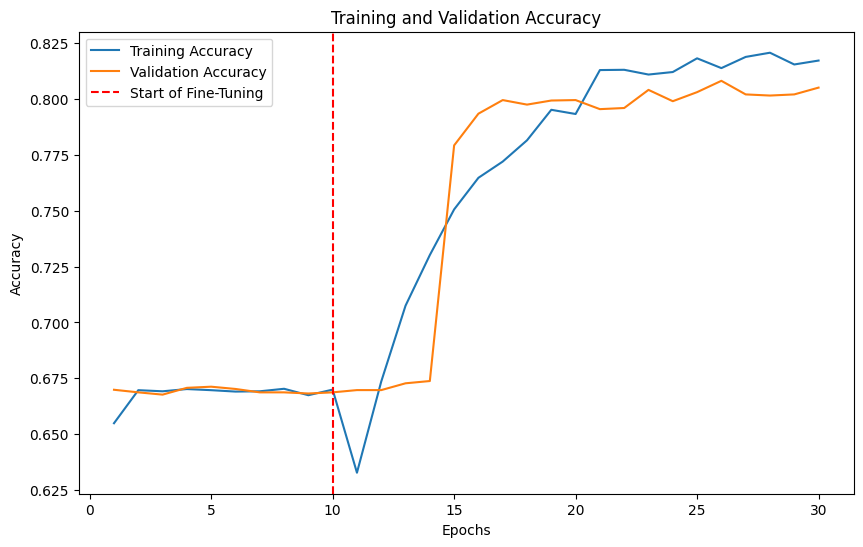

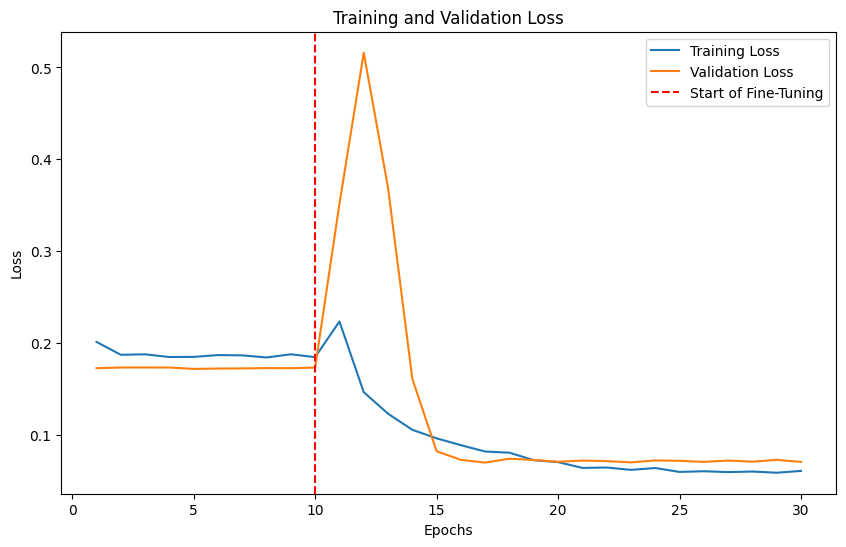

In [56]:
accuracy = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_accuracy = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x=len(history.history['accuracy']), color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x=len(history.history['loss']), color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [57]:
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step
Classification Report:
               precision    recall  f1-score   support

       akiec       0.60      0.32      0.42        65
         bcc       0.81      0.47      0.59       103
         bkl       0.54      0.75      0.63       220
          df       0.32      0.57      0.41        23
         mel       0.57      0.49      0.53       223
          nv       0.91      0.92      0.92      1341
        vasc       1.00      0.54      0.70        28

    accuracy                           0.80      2003
   macro avg       0.68      0.58      0.60      2003
weighted avg       0.81      0.80      0.80      2003



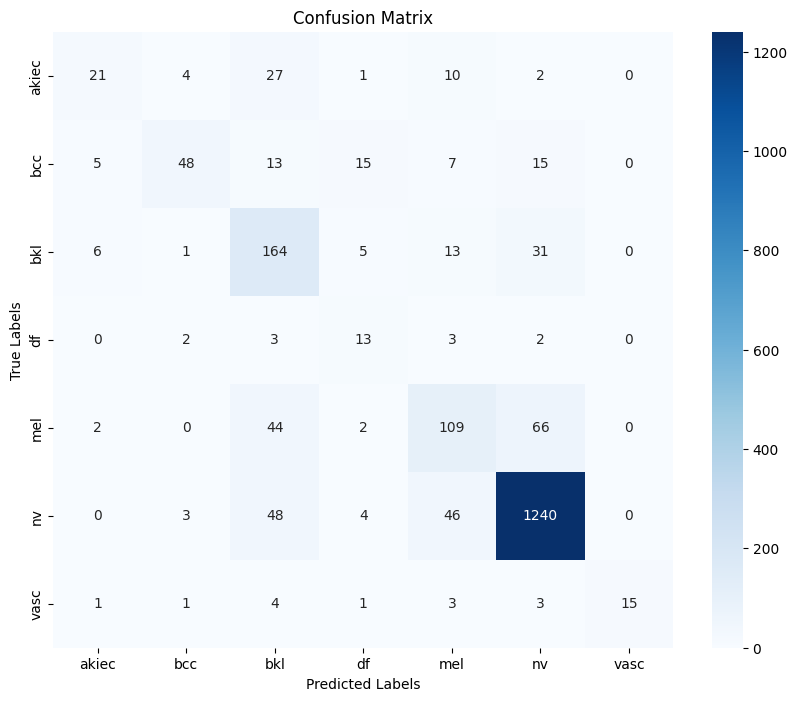

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


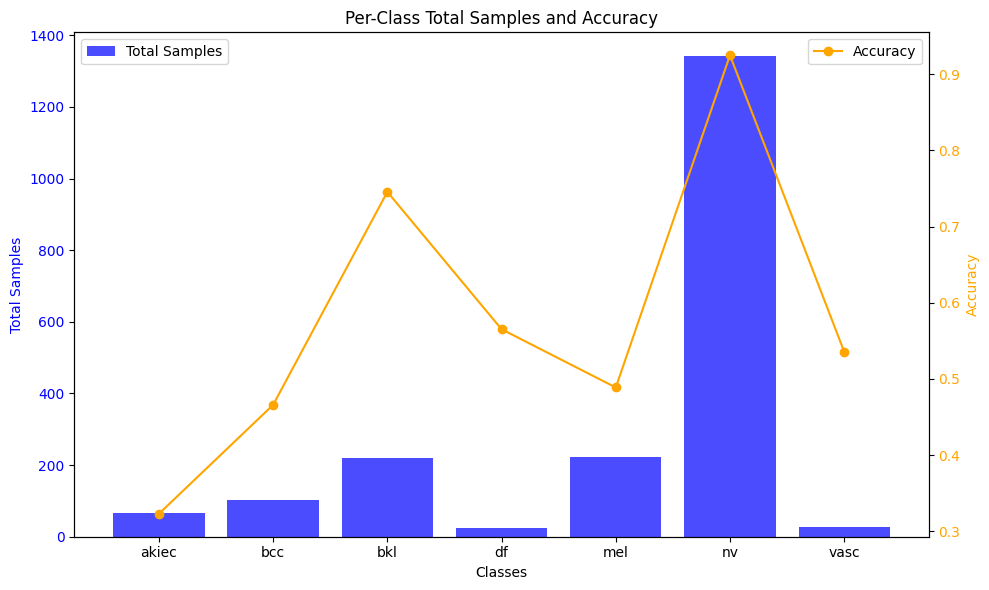

In [59]:
label_counts = np.bincount(y_true)
class_accuracies = np.diag(cm) / label_counts

classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
total_counts = label_counts
accuracies = class_accuracies

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(classes, total_counts, alpha=0.7, label='Total Samples', color='blue')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Total Samples', color='blue')
ax1.set_title('Per-Class Total Samples and Accuracy')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(classes, accuracies, color='orange', marker='o', label='Accuracy')
ax2.set_ylabel('Accuracy', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

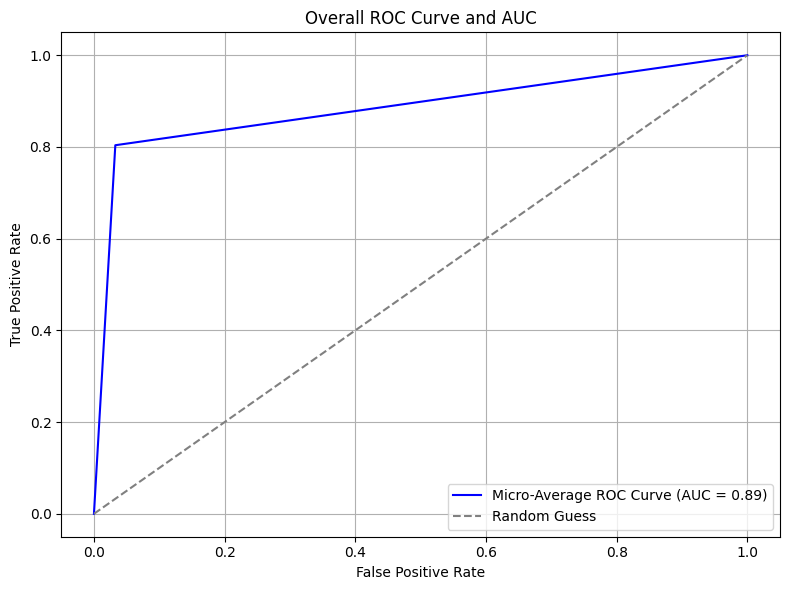

In [60]:
num_classes = len(classes)
y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))

y_pred_prob = np.zeros_like(y_true_one_hot)
for i, label in enumerate(y_pred):
    y_pred_prob[i, label] = 1

fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), y_pred_prob.ravel())
roc_auc = roc_auc_score(y_true_one_hot, y_pred_prob, average="micro")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"Micro-Average ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Overall ROC Curve and AUC")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


In [61]:
print("ROC AUC Score (Micro):", roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='micro'))
print("ROC AUC Score (Macro):", roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='macro'))
print("ROC AUC Score (Weighted):", roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='weighted'))

print("AUC Scores Per Class:")
for i, class_name in enumerate(class_names):
    class_roc_auc = roc_auc_score(y_true_one_hot[:, i], y_pred_prob[:, i])
    print(f"{class_name}: {class_roc_auc:.2f}")

ROC AUC Score (Micro): 0.88554667998003
ROC AUC Score (Macro): 0.7655725587279453
ROC AUC Score (Weighted): 0.8345304745815825
AUC Scores Per Class:
akiec: 0.66
bcc: 0.73
bkl: 0.83
df: 0.78
mel: 0.72
nv: 0.87
vasc: 0.77
